In [29]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-buc6yhtt
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-buc6yhtt
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [30]:
!/usr/local/cuda/bin/nvcc --version
#!pip install --upgrade git+https://github.com/frehseg/nvcc4jupyter.git
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-nk6a920w
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-nk6a920w
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [31]:
!apt-get -y install libopencv-dev
!apt-get -y install libopencv-core-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-core-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [32]:
%%cuda --name my_curand.cu

#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <cuda_texture_types.h>
#include <opencv2/opencv.hpp>

#define CUDA_CHECK_ERROR() do { \
    cudaError_t err = cudaGetLastError(); \
    if (err != cudaSuccess) { \
        std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
        exit(-1); \
    } \
} while (0)

__global__ void kern(const uchar* img, float* result, int width, int height) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int jdx = blockIdx.y * blockDim.y + threadIdx.y;

    if (idx < width * 2 && jdx < height * 2) {
        int x = idx / 2;
        int y = jdx / 2;

        if (x < width - 1 && y < height - 1) {
            int dx = idx % 2;
            int dy = jdx % 2;

            int x1 = min(x + 1, width - 1);
            int y1 = min(y + 1, height - 1);

            result[idx * height * 2 + jdx] =
                img[x * height + y] * (1 - dx) * (1 - dy) +
                img[x * height + y1] * (1 - dx) * dy +
                img[x1 * height + y] * dx * (1 - dy) +
                img[x1 * height + y1] * dx * dy;
        }
    }
}

std::pair<float*, float> gpu_bilinear_interpolation(const uchar* img, int width, int height) {
    int threads_per_block_x = 8;
    int threads_per_block_y = 8;
    int blocks_per_grid_x = (width * 2 + threads_per_block_x - 1) / threads_per_block_x;
    int blocks_per_grid_y = (height * 2 + threads_per_block_y - 1) / threads_per_block_y;

    dim3 threads_per_block(threads_per_block_x, threads_per_block_y);
    dim3 blocks_per_grid(blocks_per_grid_x, blocks_per_grid_y);

    float* result_dev;
    cudaMalloc((void**)&result_dev, sizeof(float) * width * 2 * height * 2);
    CUDA_CHECK_ERROR();

    uchar* img_dev;
    cudaMalloc((void**)&img_dev, sizeof(uchar) * width * height);
    CUDA_CHECK_ERROR();

    cudaMemcpy(img_dev, img, sizeof(uchar) * width * height, cudaMemcpyHostToDevice);
    CUDA_CHECK_ERROR();

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    kern<<<blocks_per_grid, threads_per_block>>>(img_dev, result_dev, width, height);
    cudaDeviceSynchronize();

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float elapsed_time;
    cudaEventElapsedTime(&elapsed_time, start, stop);

    float* result_host = new float[width * 2 * height * 2];
    cudaMemcpy(result_host, result_dev, sizeof(float) * width * 2 * height * 2, cudaMemcpyDeviceToHost);
    CUDA_CHECK_ERROR();

    cudaFree(result_dev);
    cudaFree(img_dev);

    return std::make_pair(result_host, elapsed_time / 1000);
}

float* cpu_bilinear_interpolation(const uchar* img, int width, int height) {
    float* result = new float[width * 2 * height * 2];

    for (int idx = 0; idx < width * 2; ++idx) {
        for (int jdx = 0; jdx < height * 2; ++jdx) {
            int x = idx / 2;
            int y = jdx / 2;

            if (x < width - 1 && y < height - 1) {
                int dx = idx % 2;
                int dy = jdx % 2;

                int x1 = std::min(x + 1, width - 1);
                int y1 = std::min(y + 1, height - 1);

                result[idx * height * 2 + jdx] =
                    img[x * height + y] * (1 - dx) * (1 - dy) +
                    img[x * height + y1] * (1 - dx) * dy +
                    img[x1 * height + y] * dx * (1 - dy) +
                    img[x1 * height + y1] * dx * dy;
            }
        }
    }

    return result;
}

std::pair<float*, float> cpu_bilinear_interpolation_time(const uchar* img, int width, int height) {
    auto start_time = std::chrono::high_resolution_clock::now();

    float* result = cpu_bilinear_interpolation(img, width, height);

    auto end_time = std::chrono::high_resolution_clock::now();
    float elapsed_time = std::chrono::duration_cast<std::chrono::milliseconds>(end_time - start_time).count() / 1000.0f;

    return std::make_pair(result, elapsed_time);
}

void save_image(const std::string& filename, const float* data, int width, int height) {
    cv::Mat output_image(height * 2, width * 2, CV_32F, (void*)data);
    output_image.convertTo(output_image, CV_8U);
    cv::imwrite(filename, output_image);
}

int main() {
    cv::Mat image = cv::imread("picture1200.bmp", cv::IMREAD_GRAYSCALE);
    if (image.empty()) {
        std::cerr << "Error: Could not read input image." << std::endl;
        return -1;
    }

    int width = image.cols;
    int height = image.rows;

    std::cout << "Input Image Dimensions: " << height << " x " << width << std::endl;

    auto [result_gpu, result_time_gpu] = gpu_bilinear_interpolation(image.data, width, height);

    auto [result_cpu, result_time_cpu] = cpu_bilinear_interpolation_time(image.data, width, height);

    std::cout << "GPU Execution Time: " << result_time_gpu << " seconds" << std::endl;
    std::cout << "CPU Execution Time: " << result_time_cpu << " seconds" << std::endl;
    std::cout << "Time CPU/GPU: " << result_time_cpu / result_time_gpu << std::endl;

    // Сохраняем результаты
    save_image("1200result_gpu.bmp", result_gpu, width, height);
    save_image("1200result_cpu.bmp", result_cpu, width, height);

    delete[] result_gpu;
    delete[] result_cpu;

    return 0;
}

'File written in /content/src/my_curand.cu'

In [33]:
!apt-get -y install libopencv-dev
!apt-get -y install libopencv-core-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-core-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [34]:
!nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand -lcublas -I/usr/include/opencv4 -I/usr/include -L/usr/lib -lopencv_core -lopencv_highgui -lopencv_imgproc -lopencv_imgcodecs

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [35]:
!/content/src/my_curand

Input Image Dimensions: 1200 x 1200
GPU Execution Time: 0.000605184 seconds
CPU Execution Time: 0.171 seconds
Time CPU/GPU: 282.559


In [36]:
!pip install matplotlib

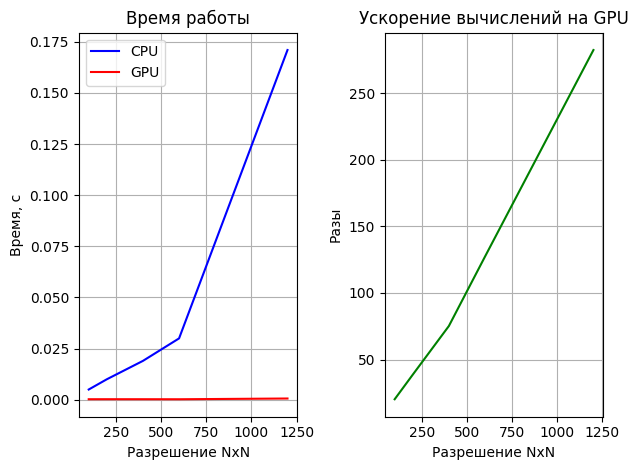

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [100, 200, 400, 600, 1200]
gpu_time = [0.000248208, 0.000259104, 0.000252736, 0.000235552, 0.000605184]
cpu_time = [0.005, 0.01, 0.019, 0.03, 0.171]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Разрешение NxN")
axes[0].set_ylabel("Время, с")
axes[0].set_title("Время работы")

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Разрешение NxN")
axes[1].set_ylabel("Разы")
axes[1].set_title("Ускорение вычислений на GPU")

plt.tight_layout()
plt.show()